# Chapter 9
## 章节 9.1：IMDB评论分类（词嵌入）
## Section 9.1: IMDB Reviews Classification with Embedding

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import os, matplotlib

imdb, info = tfds.load('imdb_reviews', with_info = True, as_supervised = True)

In [2]:
import numpy as np

training_sentences, training_label = [], []
testing_sentences, testing_label = [], []

print('原始数据集的格式：')
for data, label in imdb['train']:
    print('数据：', data)
    print('标签：', label)
    break

for data, label in imdb['train']:
    training_sentences.append(str(data.numpy()))
    training_label.append(label.numpy())
for data, label in imdb['test']:
    testing_sentences.append(str(data.numpy()))
    testing_label.append(label)

training_sentences = np.array(training_sentences)
training_label = np.array(training_label)

testing_sentences = np.array(testing_sentences)
testing_label = np.array(testing_label)

print('现在数据集的格式：')
print('数据：',training_sentences[0])
print('标签：',training_label[0])

原始数据集的格式：
数据： tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
标签： tf.Tensor(0, shape=(), dtype=int64)
现在数据集的格式：
数据： b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even t

In [3]:
numWords = 25000
oov = '<OOV>'
maxLen = 1000 # dim = 20: 200: 87.68%, 250: 88.03%; dim = 16: 300: 88.52%, 400: 0.888, 600:0.8899
truncType = 'post'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = numWords, oov_token = oov)

tokenizer.fit_on_texts(training_sentences)
word_to_index = tokenizer.word_index
index_to_word = dict([(value, key) for key, value in word_to_index.items()])

training_sequence = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequence, maxlen= maxLen, padding = 'post', truncating = truncType)

testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, maxlen = maxLen)

In [4]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(numWords, embedding_dim, input_length = maxLen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

model.compile(loss ='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 16)          400000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 400,073
Trainable params: 400,073
Non-trainable params: 0
_________________________________________________________________


In [5]:
num_epochs = 10 # 基本10次以内就会过拟合 最高：89.10%
history = model.fit(training_padded, training_label, epochs=num_epochs, validation_data=(testing_padded, testing_label))

Epoch 1/10
782/782 [==============================] - 14s 16ms/step - loss: 0.6842 - accuracy: 0.6013 - val_loss: 0.5968 - val_accuracy: 0.7529
Epoch 2/10
782/782 [==============================] - 12s 15ms/step - loss: 0.5146 - accuracy: 0.8160 - val_loss: 0.3824 - val_accuracy: 0.8623
Epoch 3/10
782/782 [==============================] - 12s 15ms/step - loss: 0.3252 - accuracy: 0.8851 - val_loss: 0.3326 - val_accuracy: 0.8650
Epoch 4/10
782/782 [==============================] - 13s 16ms/step - loss: 0.2597 - accuracy: 0.9069 - val_loss: 0.2968 - val_accuracy: 0.8840
Epoch 5/10
782/782 [==============================] - 14s 18ms/step - loss: 0.2238 - accuracy: 0.9183 - val_loss: 0.3013 - val_accuracy: 0.8793
Epoch 6/10
782/782 [==============================] - 13s 16ms/step - loss: 0.1925 - accuracy: 0.9305 - val_loss: 0.2798 - val_accuracy: 0.8903
Epoch 7/10
782/782 [==============================] - 12s 16ms/step - loss: 0.1693 - accuracy: 0.9400 - val_loss: 0.2856 - val_accuracy:

<Figure size 432x288 with 0 Axes>

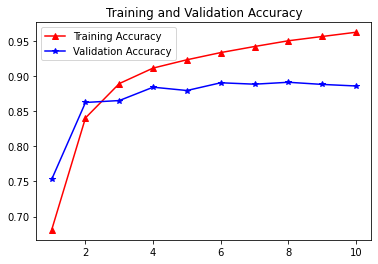

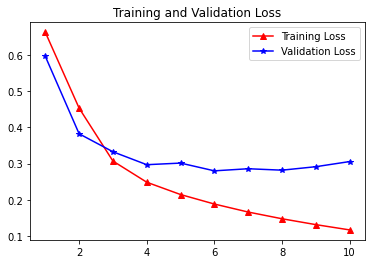

<Figure size 432x288 with 0 Axes>

In [6]:
loss,acc,val_loss,val_acc = history.history.values()
epochs = range(1,len(loss)+1)
import matplotlib.pyplot as plt
# Plot graph
plt.plot(epochs,acc,'r-^',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b-*', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r-^',label='Training Loss')
plt.plot(epochs,val_loss,'b-*',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

In [7]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(25000, 16)


In [8]:
out_v = open('9.1_imdb_reviews_vecs.tsv', 'w', encoding='utf-8')
out_m = open('9.1_imdb_reviews_meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, numWords):
    word = index_to_word[word_num]
    embeddings = weights[word_num]
    out_m.write(word+'\n')
    out_v.write('\t'.join([str(x) for x in embeddings])+'\n')

out_m.close()
out_v.close()

## 可视化结果
- 打开 http://projector.tensorflow.org/ 
- Load 9.1_imdb_reviews_vecs.tsv 和 9.1_imdb_reviews_meta.tsv文件
- 选择球面化
- 发现单词已经聚类向两侧了